In [33]:
# Importing necessary libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
import re
import spacy
import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, precision_score, recall_score, f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import HistGradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

In [2]:
# Loading the dataset
df = pd.read_excel('SEFACED_Email_Forensic_Dataset.xlsx')

<b>Dataset Description: </b>The dataset used in this study is an amalgamation of 3 existing datasets and 1 newly created datasets. The dataset contains Normal e-mails from Enron Corpora, Fraudulent e-mails provided by Phished e-mails corpora which contain misleading information, Harassment messages selected from “Hate Speech & Offensive Dataset". We enhanced the dataset of Email Forensics by adding the suspicious emails data from our personal email sources, and twitter source. The suspicious dataset contains some terrorism-related messages collected from Twitter by API. These different datasets are merged into a structural file to make the multiclass E-mail classification possible. The number of Normal, Fraudulent, Harassment, and Suspicious emails are 9001, 9001, 9138, and 5287 respectively. The header information such as sender, subject, CC, and BCC are removed; only the Email body’s content is used for analysis. The dataset after composition contains about 32,427 messages.

In [3]:
# Displaying the first five records of the dataset
df.head()

,Text,Class_Label
0,Let me know when you get the quotes from Pauli...,Normal
1,---------------------- Forwarded by Phillip K ...,Normal
2,"Steve, Please remove Bob Shiring and Liz River...",Normal
3,Go ahead and order the ac for #27. Can you ema...,Normal
4,Anymore details? Is the offer above or below 6...,Normal


In [4]:
# Displaying the shape of the dataset i.e. (no. of records, no. of attributes)
df.shape

(42153, 2)

In [5]:
# Displaying the unique class labels
df['Class_Label'].unique()

array(['Normal', 'Suspicious', 'Fraudulent', 'Harrasment'], dtype=object)

In [6]:
# Displaying the entire text for first five records with Class_Label = Normal
for text in df[df['Class_Label']=='Normal']['Text'].head():
    print(text,'\n')

Let me know when you get the quotes from Pauline. I am expecting to pay something in the $3,000 to $5,000 range. I would like to see the quotes and a description of the work to be done. It is my understanding that some rock will be removed and replaced with siding. If they are getting quotes to put up new rock then we will need to clarify. Jacques is ready to drop in a dollar amount on the release. If the negotiations stall, it seems like I need to go ahead and cut off the utilities. Hopefully things will go smoothly. Phillip 

---------------------- Forwarded by Phillip K Allen/HOU/ECT on 04/24/2001 02:23 PM --------------------------- Eric Benson@ENRON on 04/24/2001 11:47:40 AM To: Phillip K Allen/HOU/ECT@ECT cc: Subject: Instructions for FERC Meetings Mr. Allen - Per our phon 

Steve, Please remove Bob Shiring and Liz Rivera from rc #768. Thank you Phillip Allen 

Go ahead and order the ac for #27. Can you email or fax a summary of all rents collected from August through December. I

In [7]:
# Displaying the entire text for first five records with Class_Label = Suspicious
for text in df[df['Class_Label']=='Suspicious']['Text'].head():
    print(text,'\n')

Re: Chris Stevens 

FVV: Cairo Condemnation - Final 

nan 

Meet The Right Wing Extremist Behind Anti-Muslim Film That Sparked Deadly Riots 

FW: Anti-Muslim film director in hiding, following Libya, Egypt violence 



In [8]:
# Displaying the entire text for first five records with Class_Label = Fraudulent
for text in df[df['Class_Label']=='Fraudulent']['Text'].head():
    print(text,'\n')

Supply Quality China's EXCLUSIVE dimensions at Unbeatable Price.Dear Sir, We are pleased to inform you as one of China's largest export & import sto=ne company-Wanlistone Group, The Group its subsidia... 

Dear Friend,Greetings to you.I wish to accost you with a request that would be of immense benefit to both of us. Being an executor of wills, it is possible that we may be tempted to make fortune out o... 

MR. CHEUNG PUIHANG SENG BANK LTD.DES VOEUX RD. BRANCH,CENTRAL HONG KONG,HONG KONG. Let me start by introducing myself. I am Mr.Cheung Pui director of operations of the Hang Seng Bank Ltd. I have an ur... 

Greetings from barrister Robert Williams=2CDear friend=2C I know that my letter will come to you as a surprise=2C b=ased on the fact that we have not been in contact for the first time eit=her in pers... 

SOLICITING FOR A BUSINESS VENTURE AND PARTNESHIP.DEAR SIR,I AM THE SON OF THE LATE PRESIDENT OF THE FEDERAL REPUBLIC OF ZAIRE, =PRESIDENT MOBUTU SESE SEKO,(NOW REPUBLIC OF CONG

In [9]:
# Displaying the entire text for first five records with Class_Label = Harrasment
for text in df[df['Class_Label']=='Harrasment']['Text'].head():
    print(text,'\n')

!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!! 

!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit 

!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny 

!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361; 

!!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just blows me..claim you so faithful and down for somebody but still fucking with hoes! &#128514;&#128514;&#128514;" 



In [10]:
# Checking whether the dataset has missing values
df.isnull().sum()

Text           136
Class_Label      0
dtype: int64

In [11]:
# Removing the records having missing values annd resetting the index
df.dropna(axis=0, inplace=True)
df.reset_index(inplace=True)
df.drop(['index'], axis=1, inplace=True)

In [12]:
# Copying and storing all the text into another variable
text = df['Text'].copy()

In [13]:
# Changing the datatype of all the content into string
for i in range(len(text)):
    if type(text[i]) is not str:
        text[i] = str(text[i])

In [14]:
# Expanding all contractions
for i in range(len(text)):
    expanded_words = []
    for word in text[i].split():
        expanded_words.append(contractions.fix(word))
    text[i] = ' '.join(expanded_words)

In [15]:
# Removing all special characters and numbers, along with multiple white space characters
for i in range(len(text)):
    text[i] = re.sub(r'[^\w\s]', ' ', text[i])
    text[i] = re.sub(r'[\d\n\r]', ' ', text[i])
    text[i] = re.sub(r'_+', ' ', text[i])
    text[i] = re.sub(r' +', ' ', text[i])

In [16]:
# Loading the english language model
model = spacy.load('en_core_web_sm')

In [17]:
# Processing each of the email content using the language model
processed_content = [model(sentence) for sentence in text]

In [18]:
# Extracting the lemmas for each of the email content
for i in range(len(text)):
    text[i] = [token.lemma_ for token in processed_content[i]]
    text[i] = [word.lower() for word in text[i] if word != ' ']

In [19]:
# Replacing the original text in the dataset with the preprocessed text
df['Text'] = [' '.join(text[i]) for i in range(len(text))]

In [20]:
# Displaying the first five records of the modified dataset
df.head()

,Text,Class_Label
0,let i know when you get the quote from pauline...,Normal
1,forward by phillip k allen hou ect on pm eric ...,Normal
2,steve please remove bob shiring and liz rivera...,Normal
3,go ahead and order the ac for can you email or...,Normal
4,anymore detail be the offer above or below wha...,Normal


In [21]:
# Converting the lists of tokens to a matrix of token counts
vectorizer = CountVectorizer(lowercase=False, strip_accents='ascii', analyzer='word', stop_words='english', min_df=5)
X = vectorizer.fit_transform(df['Text'])

In [22]:
# Converting the matrix of token counts into tf-idf matrix
transformer = TfidfTransformer()
X = transformer.fit_transform(X)

In [23]:
# Performing latent semantic analysis on the tf-idf matrix
lsa = TruncatedSVD(n_components=100)
X = lsa.fit_transform(X)

In [24]:
# Normalizing the values using MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [25]:
# Creating an array containing the class labels
y = np.array(df['Class_Label'])

In [26]:
# Encoding the class labels using LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)

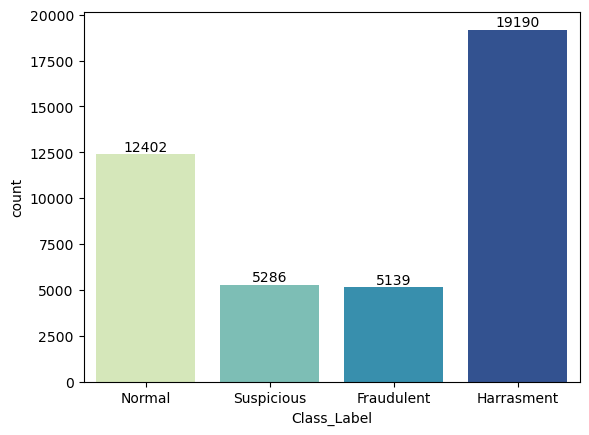

In [27]:
# Checking for class imbalance
ax = sns.countplot(x=df['Class_Label'], palette='YlGnBu')
ax.bar_label(ax.containers[0]);

In [28]:
# Handling class imbalance by oversampling using RandomOverSampler
oversampler = RandomOverSampler()
X,y = oversampler.fit_resample(X,y)

In [29]:
# Splitting the dataset in a 80:20 train-test split ratio
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
conf_mat = {}
acc = {}

## XGBoost Classifier

In [31]:
# Creating an instance of the model
model = XGBClassifier()

In [34]:
# Performing stratified k-fold cross validation on training data
sk_folds = StratifiedKFold(n_splits = 5)

table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

accuracy = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'accuracy')
table.add_row(["Accuracy Score", accuracy])
table.add_row(['',''])
table.add_row(["Average Accuracy Score", accuracy.mean()])
table.add_row(['',''])

precision = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'precision_micro')
table.add_row(["Precision Score", precision])
table.add_row(['',''])
table.add_row(["Average Precision Score", precision.mean()])
table.add_row(['',''])

recall = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'recall_micro')
table.add_row(["Recall Score",  recall])
table.add_row(['',''])
table.add_row(["Average Recall Score",  recall.mean()])
table.add_row(['',''])
        
f1 = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'f1_micro')
table.add_row(["F1 Score", f1])
table.add_row(['',''])
table.add_row(["Average F1 Score",  f1.mean()])
        
print(table)
print()

+-------------------------+----------------------------------------------------------+
|    Evaluation Metric    |                          Value                           |
+-------------------------+----------------------------------------------------------+
|      Accuracy Score     | [0.98436737 0.98192477 0.97769093 0.9782591  0.97964335] |
|                         |                                                          |
|  Average Accuracy Score |                    0.9803771031175857                    |
|                         |                                                          |
|     Precision Score     | [0.98436737 0.98192477 0.97769093 0.9782591  0.97964335] |
|                         |                                                          |
| Average Precision Score |                    0.9803771031175857                    |
|                         |                                                          |
|       Recall Score      | [0.98436737 0.9

In [35]:
# Fitting model on training data
model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [36]:
# Predicting class label for test data
y_pred = model.predict(X_test)

In [37]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

conf_mat['XGBoost'] = confusion_matrix(y_test,y_pred)
acc['XGBoost'] = accuracy_score(y_test,y_pred)

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+--------------------+
| Evaluation Metric |       Value        |
+-------------------+--------------------+
|      Accuracy     | 0.9850182386659718 |
|     Precision     | 0.9850182386659718 |
|       Recall      | 0.9850182386659718 |
|      F1 Score     | 0.9850182386659718 |
+-------------------+--------------------+


## Decision Tree Classifier

In [38]:
# Creating an instance of the model
model = DecisionTreeClassifier()

In [39]:
# Performing stratified k-fold cross validation on training data
sk_folds = StratifiedKFold(n_splits = 5)

table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

accuracy = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'accuracy')
table.add_row(["Accuracy Score", accuracy])
table.add_row(['',''])
table.add_row(["Average Accuracy Score", accuracy.mean()])
table.add_row(['',''])

precision = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'precision_micro')
table.add_row(["Precision Score", precision])
table.add_row(['',''])
table.add_row(["Average Precision Score", precision.mean()])
table.add_row(['',''])

recall = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'recall_micro')
table.add_row(["Recall Score",  recall])
table.add_row(['',''])
table.add_row(["Average Recall Score",  recall.mean()])
table.add_row(['',''])
        
f1 = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'f1_micro')
table.add_row(["F1 Score", f1])
table.add_row(['',''])
table.add_row(["Average F1 Score",  f1.mean()])
        
print(table)
print()

+-------------------------+----------------------------------------------------------+
|    Evaluation Metric    |                          Value                           |
+-------------------------+----------------------------------------------------------+
|      Accuracy Score     | [0.96914183 0.96466374 0.96303534 0.96376517 0.96466086] |
|                         |                                                          |
|  Average Accuracy Score |                    0.9650533858658841                    |
|                         |                                                          |
|     Precision Score     | [0.96832763 0.96588504 0.96254682 0.96343946 0.96376517] |
|                         |                                                          |
| Average Precision Score |                    0.9647928220912723                    |
|                         |                                                          |
|       Recall Score      | [0.96588504 0.9

In [40]:
# Fitting model on training data
model.fit(X_train,y_train)

DecisionTreeClassifier()

In [41]:
# Predicting class label for test data
y_pred = model.predict(X_test)

In [42]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

conf_mat['Decision Tree'] = confusion_matrix(y_test,y_pred)
acc['Decision Tree'] = accuracy_score(y_test,y_pred)

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+--------------------+
| Evaluation Metric |       Value        |
+-------------------+--------------------+
|      Accuracy     | 0.9730328295987494 |
|     Precision     | 0.9730328295987494 |
|       Recall      | 0.9730328295987494 |
|      F1 Score     | 0.9730328295987494 |
+-------------------+--------------------+


## HistGradientBoostingClassifier

In [43]:
# Creating an instance of the model
model = HistGradientBoostingClassifier()

In [44]:
# Performing stratified k-fold cross validation on training data
sk_folds = StratifiedKFold(n_splits = 5)

table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

accuracy = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'accuracy')
table.add_row(["Accuracy Score", accuracy])
table.add_row(['',''])
table.add_row(["Average Accuracy Score", accuracy.mean()])
table.add_row(['',''])

precision = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'precision_micro')
table.add_row(["Precision Score", precision])
table.add_row(['',''])
table.add_row(["Average Precision Score", precision.mean()])
table.add_row(['',''])

recall = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'recall_micro')
table.add_row(["Recall Score",  recall])
table.add_row(['',''])
table.add_row(["Average Recall Score",  recall.mean()])
table.add_row(['',''])
        
f1 = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'f1_micro')
table.add_row(["F1 Score", f1])
table.add_row(['',''])
table.add_row(["Average F1 Score",  f1.mean()])
        
print(table)
print()

+-------------------------+----------------------------------------------------------+
|    Evaluation Metric    |                          Value                           |
+-------------------------+----------------------------------------------------------+
|      Accuracy Score     | [0.97850513 0.97703957 0.97345709 0.97247781 0.97239638] |
|                         |                                                          |
|  Average Accuracy Score |                    0.9747751974303194                    |
|                         |                                                          |
|     Precision Score     | [0.97842371 0.97744667 0.97329425 0.9730478  0.97410634] |
|                         |                                                          |
| Average Precision Score |                    0.9752637543419725                    |
|                         |                                                          |
|       Recall Score      | [0.97899365 0.9

In [45]:
# Fitting model on training data
model.fit(X_train,y_train)

HistGradientBoostingClassifier()

In [46]:
# Predicting class label for test data
y_pred = model.predict(X_test)

In [47]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

conf_mat['Histogram-Based Gradient Boosting Tree'] = confusion_matrix(y_test,y_pred)
acc['Histogram-Based Gradient Boosting Tree'] = accuracy_score(y_test,y_pred)

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+--------------------+
| Evaluation Metric |       Value        |
+-------------------+--------------------+
|      Accuracy     | 0.9791558103178739 |
|     Precision     | 0.9791558103178739 |
|       Recall      | 0.9791558103178739 |
|      F1 Score     | 0.9791558103178739 |
+-------------------+--------------------+


## AdaBoostClassifier

In [48]:
# Creating an instance of the model
model = AdaBoostClassifier()

In [49]:
# Performing stratified k-fold cross validation on training data
sk_folds = StratifiedKFold(n_splits = 5)

table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

accuracy = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'accuracy')
table.add_row(["Accuracy Score", accuracy])
table.add_row(['',''])
table.add_row(["Average Accuracy Score", accuracy.mean()])
table.add_row(['',''])

precision = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'precision_micro')
table.add_row(["Precision Score", precision])
table.add_row(['',''])
table.add_row(["Average Precision Score", precision.mean()])
table.add_row(['',''])

recall = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'recall_micro')
table.add_row(["Recall Score",  recall])
table.add_row(['',''])
table.add_row(["Average Recall Score",  recall.mean()])
table.add_row(['',''])
        
f1 = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'f1_micro')
table.add_row(["F1 Score", f1])
table.add_row(['',''])
table.add_row(["Average F1 Score",  f1.mean()])
        
print(table)
print()

+-------------------------+----------------------------------------------------------+
|    Evaluation Metric    |                          Value                           |
+-------------------------+----------------------------------------------------------+
|      Accuracy Score     | [0.84245237 0.81436248 0.78448135 0.81532448 0.75156746] |
|                         |                                                          |
|  Average Accuracy Score |                    0.801637630547906                     |
|                         |                                                          |
|     Precision Score     | [0.84245237 0.81436248 0.78448135 0.81532448 0.75156746] |
|                         |                                                          |
| Average Precision Score |                    0.801637630547906                     |
|                         |                                                          |
|       Recall Score      | [0.84245237 0.8

In [50]:
# Fitting model on training data
model.fit(X_train,y_train)

AdaBoostClassifier()

In [51]:
# Predicting class label for test data
y_pred = model.predict(X_test)

In [52]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

conf_mat['AdaBoost'] = confusion_matrix(y_test,y_pred)
acc['AdaBoost'] = accuracy_score(y_test,y_pred)

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+--------------------+
| Evaluation Metric |       Value        |
+-------------------+--------------------+
|      Accuracy     | 0.7745570609692548 |
|     Precision     | 0.7745570609692548 |
|       Recall      | 0.7745570609692548 |
|      F1 Score     | 0.7745570609692548 |
+-------------------+--------------------+


## Random Forest Classifier

In [53]:
# Creating an instance of the model
model = RandomForestClassifier()

In [54]:
# Performing stratified k-fold cross validation on training data
sk_folds = StratifiedKFold(n_splits = 5)

table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

accuracy = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'accuracy')
table.add_row(["Accuracy Score", accuracy])
table.add_row(['',''])
table.add_row(["Average Accuracy Score", accuracy.mean()])
table.add_row(['',''])

precision = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'precision_micro')
table.add_row(["Precision Score", precision])
table.add_row(['',''])
table.add_row(["Average Precision Score", precision.mean()])
table.add_row(['',''])

recall = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'recall_micro')
table.add_row(["Recall Score",  recall])
table.add_row(['',''])
table.add_row(["Average Recall Score",  recall.mean()])
table.add_row(['',''])
        
f1 = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'f1_micro')
table.add_row(["F1 Score", f1])
table.add_row(['',''])
table.add_row(["Average F1 Score",  f1.mean()])
        
print(table)
print()

+-------------------------+----------------------------------------------------------+
|    Evaluation Metric    |                          Value                           |
+-------------------------+----------------------------------------------------------+
|      Accuracy Score     | [0.98591435 0.98298323 0.97972643 0.98078332 0.98249328] |
|                         |                                                          |
|  Average Accuracy Score |                    0.9823801217490009                    |
|                         |                                                          |
|     Precision Score     | [0.98550725 0.98404169 0.97948217 0.97964335 0.98338897] |
|                         |                                                          |
| Average Precision Score |                    0.9824126857568206                    |
|                         |                                                          |
|       Recall Score      | [0.98648429 0.9

In [55]:
# Fitting model on training data
model.fit(X_train,y_train)

RandomForestClassifier()

In [56]:
# Predicting class label for test data
y_pred = model.predict(X_test)

In [57]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

conf_mat['Random Forest'] = confusion_matrix(y_test,y_pred)
acc['Random Forest'] = accuracy_score(y_test,y_pred)

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+--------------------+
| Evaluation Metric |       Value        |
+-------------------+--------------------+
|      Accuracy     | 0.9873632100052111 |
|     Precision     | 0.9873632100052111 |
|       Recall      | 0.9873632100052111 |
|      F1 Score     | 0.9873632100052111 |
+-------------------+--------------------+


## ExtraTreesClassifier

In [58]:
# Creating an instance of the model
model = ExtraTreesClassifier()

In [59]:
# Performing stratified k-fold cross validation on training data
sk_folds = StratifiedKFold(n_splits = 5)

table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

accuracy = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'accuracy')
table.add_row(["Accuracy Score", accuracy])
table.add_row(['',''])
table.add_row(["Average Accuracy Score", accuracy.mean()])
table.add_row(['',''])

precision = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'precision_micro')
table.add_row(["Precision Score", precision])
table.add_row(['',''])
table.add_row(["Average Precision Score", precision.mean()])
table.add_row(['',''])

recall = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'recall_micro')
table.add_row(["Recall Score",  recall])
table.add_row(['',''])
table.add_row(["Average Recall Score",  recall.mean()])
table.add_row(['',''])
        
f1 = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'f1_micro')
table.add_row(["F1 Score", f1])
table.add_row(['',''])
table.add_row(["Average F1 Score",  f1.mean()])
        
print(table)
print()

+-------------------------+----------------------------------------------------------+
|    Evaluation Metric    |                          Value                           |
+-------------------------+----------------------------------------------------------+
|      Accuracy Score     | [0.98827553 0.98550725 0.98159909 0.98208615 0.98461037] |
|                         |                                                          |
|  Average Accuracy Score |                    0.9844156765432842                    |
|                         |                                                          |
|     Precision Score     | [0.98737991 0.98632145 0.98184335 0.98281899 0.98452895] |
|                         |                                                          |
| Average Precision Score |                    0.9845785270792353                    |
|                         |                                                          |
|       Recall Score      | [0.98705423 0.9

In [60]:
# Fitting model on training data
model.fit(X_train,y_train)

ExtraTreesClassifier()

In [61]:
# Predicting class label for test data
y_pred = model.predict(X_test)

In [62]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

conf_mat['Extra Trees'] = confusion_matrix(y_test,y_pred)
acc['Extra Trees'] = accuracy_score(y_test,y_pred)

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+--------------------+
| Evaluation Metric |       Value        |
+-------------------+--------------------+
|      Accuracy     | 0.9906852527357999 |
|     Precision     | 0.9906852527357999 |
|       Recall      | 0.9906852527357999 |
|      F1 Score     | 0.9906852527357999 |
+-------------------+--------------------+


## SVM Classifier

In [63]:
# Creating an instance of the model
model = SVC()

In [64]:
# Performing stratified k-fold cross validation on training data
sk_folds = StratifiedKFold(n_splits = 5)

table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

accuracy = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'accuracy')
table.add_row(["Accuracy Score", accuracy])
table.add_row(['',''])
table.add_row(["Average Accuracy Score", accuracy.mean()])
table.add_row(['',''])

precision = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'precision_micro')
table.add_row(["Precision Score", precision])
table.add_row(['',''])
table.add_row(["Average Precision Score", precision.mean()])
table.add_row(['',''])

recall = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'recall_micro')
table.add_row(["Recall Score",  recall])
table.add_row(['',''])
table.add_row(["Average Recall Score",  recall.mean()])
table.add_row(['',''])
        
f1 = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'f1_micro')
table.add_row(["F1 Score", f1])
table.add_row(['',''])
table.add_row(["Average F1 Score",  f1.mean()])
        
print(table)
print()

+-------------------------+----------------------------------------------------------+
|    Evaluation Metric    |                          Value                           |
+-------------------------+----------------------------------------------------------+
|      Accuracy Score     | [0.92810617 0.92053411 0.92224393 0.92166762 0.92126048] |
|                         |                                                          |
|  Average Accuracy Score |                    0.9227624642257013                    |
|                         |                                                          |
|     Precision Score     | [0.92810617 0.92053411 0.92224393 0.92166762 0.92126048] |
|                         |                                                          |
| Average Precision Score |                    0.9227624642257013                    |
|                         |                                                          |
|       Recall Score      | [0.92810617 0.9

In [65]:
# Fitting model on training data
model.fit(X_train,y_train)

SVC()

In [66]:
# Predicting class label for test data
y_pred = model.predict(X_test)

In [67]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

conf_mat['SVM'] = confusion_matrix(y_test,y_pred)
acc['SVM'] = accuracy_score(y_test,y_pred)

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+--------------------+
| Evaluation Metric |       Value        |
+-------------------+--------------------+
|      Accuracy     | 0.9260031266284523 |
|     Precision     | 0.9260031266284523 |
|       Recall      | 0.9260031266284523 |
|      F1 Score     | 0.9260031266284523 |
+-------------------+--------------------+


## Logistic Regression

In [73]:
# Creating an instance of the model
model = LogisticRegression(max_iter=1000)

In [74]:
# Performing stratified k-fold cross validation on training data
sk_folds = StratifiedKFold(n_splits = 5)

table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

accuracy = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'accuracy')
table.add_row(["Accuracy Score", accuracy])
table.add_row(['',''])
table.add_row(["Average Accuracy Score", accuracy.mean()])
table.add_row(['',''])

precision = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'precision_micro')
table.add_row(["Precision Score", precision])
table.add_row(['',''])
table.add_row(["Average Precision Score", precision.mean()])
table.add_row(['',''])

recall = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'recall_micro')
table.add_row(["Recall Score",  recall])
table.add_row(['',''])
table.add_row(["Average Recall Score",  recall.mean()])
table.add_row(['',''])
        
f1 = cross_val_score(model, X_train, y_train, cv=sk_folds, scoring = 'f1_micro')
table.add_row(["F1 Score", f1])
table.add_row(['',''])
table.add_row(["Average F1 Score",  f1.mean()])
        
print(table)
print()

+-------------------------+----------------------------------------------------------+
|    Evaluation Metric    |                          Value                           |
+-------------------------+----------------------------------------------------------+
|      Accuracy Score     | [0.91858004 0.91182218 0.91459046 0.91116359 0.90969791] |
|                         |                                                          |
|  Average Accuracy Score |                    0.9131708331133913                    |
|                         |                                                          |
|     Precision Score     | [0.91858004 0.91182218 0.91459046 0.91116359 0.90969791] |
|                         |                                                          |
| Average Precision Score |                    0.9131708331133913                    |
|                         |                                                          |
|       Recall Score      | [0.91858004 0.9

In [75]:
# Fitting model on training data
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [76]:
# Predicting class label for test data
y_pred = model.predict(X_test)

In [77]:
# Evaluating Model
table = PrettyTable()
table.field_names = ["Evaluation Metric", "Value"]

conf_mat['Logistic Regression'] = confusion_matrix(y_test,y_pred)
acc['Logistic Regression'] = accuracy_score(y_test,y_pred)

# fraction of correctly predicted instances
# 1 indicates perfect prediction accuracy and 0 indicates complete failure
table.add_row(["Accuracy", accuracy_score(y_test,y_pred)])

# ability of the classifier not to label as positive a sample that is negative
# best value is 1 and the worst value is 0
table.add_row(["Precision", precision_score(y_test, y_pred, average='micro')])

# ability of the classifier to find all the positive samples
# best value is 1 and the worst value is 0
table.add_row(["Recall", recall_score(y_test, y_pred, average='micro')])

# harmonic mean of the precision and recall
# best value is 1 and the worst value is 0
table.add_row(["F1 Score", f1_score(y_test, y_pred, average='micro')])

print(table)

+-------------------+--------------------+
| Evaluation Metric |       Value        |
+-------------------+--------------------+
|      Accuracy     | 0.9148645127670662 |
|     Precision     | 0.9148645127670662 |
|       Recall      | 0.9148645127670662 |
|      F1 Score     | 0.9148645127670662 |
+-------------------+--------------------+


In [129]:
accuracies = [round(val,4) for val in list(acc.values())]

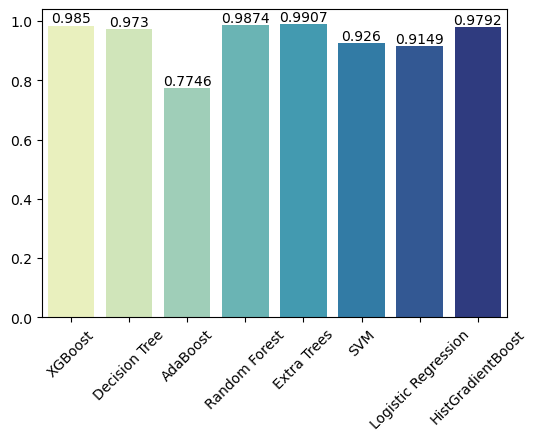

In [130]:
plt.figure(figsize=(6,4))
ax = sns.barplot(x=list(acc.keys()), y=accuracies, palette='YlGnBu')
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)
plt.show()